In [31]:
# import general libraries & data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import different models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

# import evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# import model tuning methods
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
import hyperopt

## 0. Data Preparation

In [32]:
# read data from csv file
df = pd.read_csv('cardio_train_cleaned.csv')

df.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,72,1,110,80,1,1,0,0,1,0,21.967
1,67,0,140,90,3,1,0,0,1,1,34.928
2,71,0,130,70,3,1,0,0,0,1,23.508
3,74,1,150,100,1,1,0,0,1,1,28.710
4,75,0,100,60,1,1,0,0,0,0,23.011


In [33]:
# split dataframe into variables and label
X = df.drop('cardio', axis=1)
y = df['cardio']

# scaling with StandardScalar
standardScaler = StandardScaler() 
X_norm = standardScaler.fit_transform(X)

# split data into train and validation and test
X_train, X_rem, y_train, y_rem = train_test_split(X_norm,y, train_size=0.8, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, stratify=y_rem, random_state=42)

## 1. KNN

In [34]:
# hyperparameter tuning with Hyperopt
def objective(search_space):
    neigh = KNeighborsClassifier(**search_space)
    current_score = cross_val_score(neigh, X_valid, y_valid, cv=10).mean()
    print(current_score, search_space)
    return {'loss': -current_score, 'status': STATUS_OK}

search_space = {
            'n_neighbors': hp.choice('n_neighbors', range(1, 100)),
            'weights': hp.choice('weights', ['uniform', 'distance']),
            'leaf_size': hp.choice('leaf_size', range(1,100))
        }

best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=10)
best_params_base = best_params
print('Best:')
print(best_params)
    

0.7171717771183646                                                                                                     
{'leaf_size': 70, 'n_neighbors': 98, 'weights': 'distance'}                                                            
0.7202850862732169                                                                                                     
{'leaf_size': 93, 'n_neighbors': 40, 'weights': 'uniform'}                                                             
0.7185062094735686                                                                                                     
{'leaf_size': 60, 'n_neighbors': 88, 'weights': 'distance'}                                                            
0.7239909880206616                                                                                                     
{'leaf_size': 8, 'n_neighbors': 27, 'weights': 'uniform'}                                                              
0.7064978569073526                      

In [35]:
# Get algorithm string as hp.choice only can display the integer
weights_dic = {0:'uniform', 1:'distance'}
weights = weights_dic[best_params_base['weights']]

# fit hyperparamater(Hyperopt) and train data into the model
neigh = KNeighborsClassifier(leaf_size=best_params_base['leaf_size'], n_neighbors=best_params_base['n_neighbors'], weights=weights)
model = neigh.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# evaluation metrics
accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train, average='binary')
recall = recall_score(y_train, y_pred_train, average='binary')
f1 = f1_score(y_train, y_pred_train, average='binary')

print('Train Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='binary')
recall = recall_score(y_test, y_pred_test, average='binary')
f1 = f1_score(y_test, y_pred_test, average='binary')

print('\nTest Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)

Train Results
Accuracy:  0.7418697303808024
Precision:  0.7685467588813952
Recall:  0.6768433397646881
f1_score: 0.7197859671709044

Test Results
Accuracy:  0.72561517936555
Precision:  0.7502583534274888
Recall:  0.6592009685230025
f1_score: 0.7017883035282746


## 2. Bagging with KNN

In [36]:
# hyperparameter tuning with Hyperopt
def objective(search_space):
    neigh = KNeighborsClassifier(leaf_size=best_params_base['leaf_size'], n_neighbors=best_params_base['n_neighbors'], weights=weights)
    clf = BaggingClassifier(**search_space, base_estimator=neigh)
    current_score = cross_val_score(clf, X_valid, y_valid, cv=10).mean()
    print(current_score, search_space)
    return {'loss': -current_score, 'status': STATUS_OK}

search_space = {
            'n_estimators': hp.choice('n_estimators', range(1, 1000))
        }

best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=10)
print('Best:')
print(best_params)

0.7232515661061656                                                                                                     
{'n_estimators': 42}                                                                                                   
0.7229546103967469                                                                                                     
{'n_estimators': 398}                                                                                                  
0.7241400153863062                                                                                                     
{'n_estimators': 857}                                                                                                  
0.7238430596768876                                                                                                     
{'n_estimators': 862}                                                                                                  
0.7239925266512803                      

In [41]:
# fit hyperparamater(Hyperopt) and train data into the model
neigh = KNeighborsClassifier(leaf_size=best_params_base['leaf_size'], n_neighbors=best_params_base['n_neighbors'], weights=weights)
clf = BaggingClassifier(base_estimator=neigh, n_estimators=best_params['n_estimators'], random_state=42)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# evaluation metrics
accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train, average='binary')
recall = recall_score(y_train, y_pred_train, average='binary')
f1 = f1_score(y_train, y_pred_train, average='binary')

print('Train Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='binary')
recall = recall_score(y_test, y_pred_test, average='binary')
f1 = f1_score(y_test, y_pred_test, average='binary')

print('\nTest Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)

Train Results
Accuracy:  0.7943296581117391
Precision:  0.7985824441155853
Recall:  0.775772708356978
f1_score: 0.787012339045499

Test Results
Accuracy:  0.7027868366439372
Precision:  0.7026521060842433
Recall:  0.6815980629539952
f1_score: 0.6919649715778153


## 3. AdaBoost with KNN

### Not Applicable
Adaboost classifier is a boosting algorithm, which assigns more weightage for misclassification so that it can improve accuracy in the next sequence of models that get trained. For this, the algorithm needs to use sample_weight, which is not available in the KNN classifier, as KNN only computes the nearest neighbor from train data for unknown test data, and assigns class based on max voting.
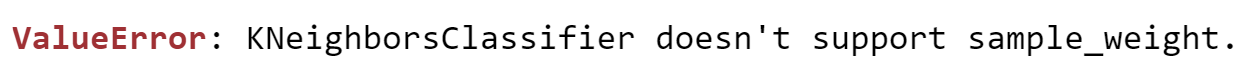

Recall improved for bagging results.